### *Importação das bibliotecas utilizadas*

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count


### **ATIVIDADE** 1
### Implementar uma função que retorne o fatiamento de bits de uma imagem em níveis de cinza de entrada

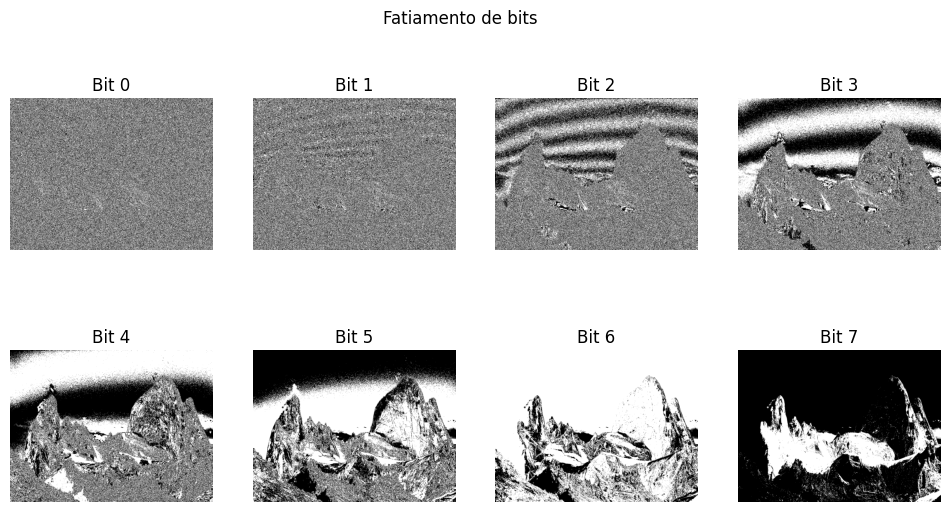

In [4]:
def fatiamento_bits(input_img):
    img = cv2.imread(input_img, cv2.IMREAD_GRAYSCALE)
    
    bit_planes = []
    
    for i in range(8):
        bit_plane = (img >> i) & 1  
        bit_planes.append(bit_plane * 255) 

    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    fig.suptitle('Fatiamento de bits')
    
    for i, ax in enumerate(axes.flat):
        ax.imshow(bit_planes[i], cmap='gray')
        ax.set_title(f'Bit {i}')
        ax.axis('off')
    
    plt.show()
    
    return bit_planes

bit_planes = fatiamento_bits("input/ex1.jpg")


### **ATIVIDADE** 2
### Pesquise e encontre amostras de imagens naturais, imagens de ultrassom, imagens de satélite (sensor landsat - pegar somente um dos canais), tomografia computadorizada e ressonância magnética. Aplicar o fatiamento de bit nelas e descartar as fatias menos relevantes e remontar a imagem
#### Fazer o fatiamento das imagens coloridas quebrando por cada um dos canais (RGB) e depois agrupar novamente


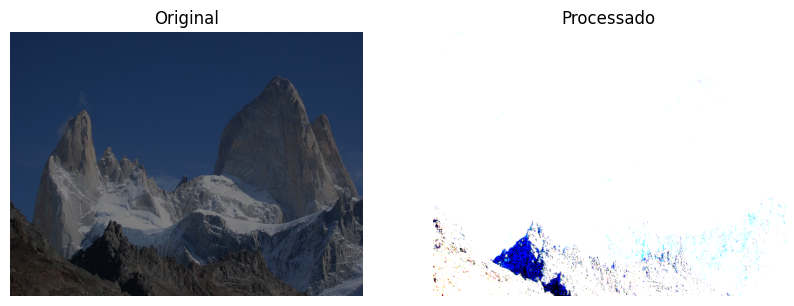

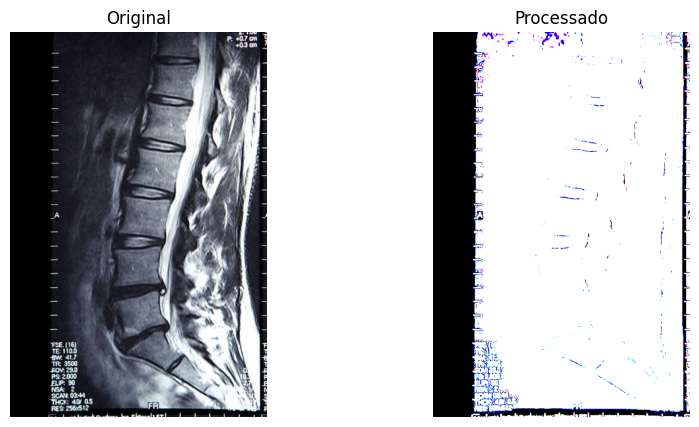

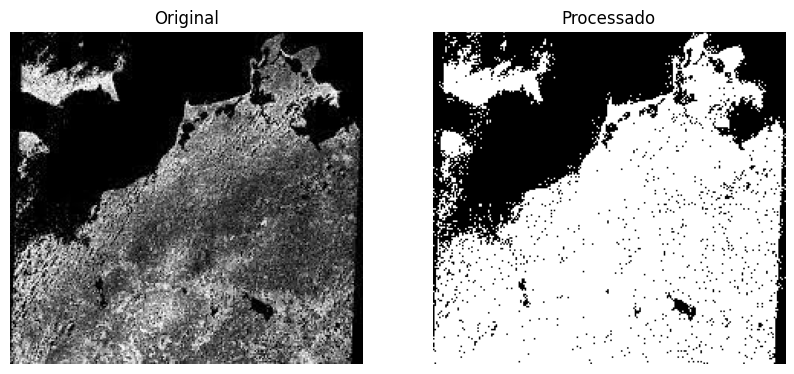

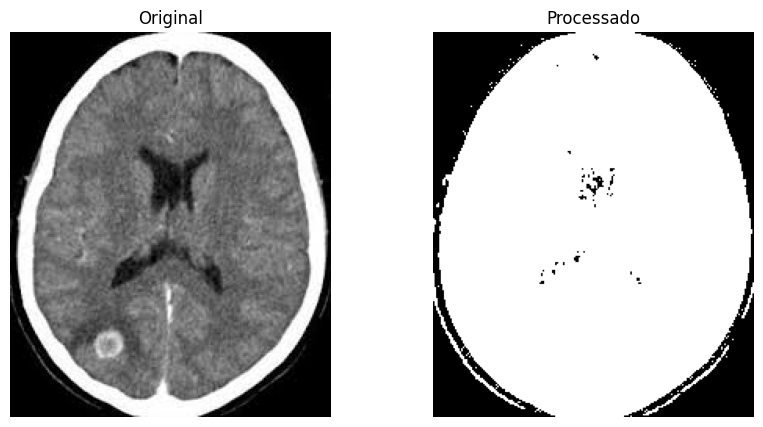

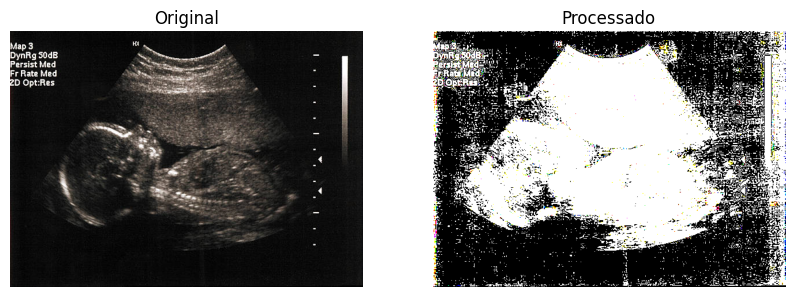

In [11]:
def fatiamento_bits(image):
    lista_bits = []  
    
    for i in range(8):
        bit_plane = (image >> i) & 1  
        lista_bits.append((bit_plane * 255).astype(np.uint8))  
    
    return lista_bits


def process_image(image_path, color=False):
    if color:
        img = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if img is None:
            raise ValueError("Erro ao carregar a imagem de entrada!\n")
        channels = cv2.split(img)
        lista_canais_proc = []
        
        for channel in channels:
            bit_planes = fatiamento_bits(channel)
            reconstructed = np.bitwise_or.reduce(bit_planes[-4:])#manter os 4 bits mais significativos
            lista_canais_proc.append(reconstructed)
        
        result_image = cv2.merge(lista_canais_proc)
    else:
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise ValueError("Erro ao carregar a imagem de entrada!\n")
        bit_planes = fatiamento_bits(img)
        result_image = np.bitwise_or.reduce(bit_planes[-4:])  #manter os 4 bits mais significativos
    
    return result_image

def display_images(original, processed):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB) if len(original.shape) == 3 else original, cmap='gray')
    plt.title('Original')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(processed, cv2.COLOR_BGR2RGB) if len(processed.shape) == 3 else processed, cmap='gray')
    plt.title('Processado')
    plt.axis('off')
    
    plt.show()

imgs = ["ex2_natural.jpg", "ex2_ressonancia.jpg", "ex2_satelite.jpg", "ex2_tomografia.jpg","ex2_ultra.jpg"]
# imgs = ["ex2_natural.jpg"]

for img_path in imgs:
    processed = process_image(f"input/{img_path}", color=True)
    original = cv2.imread(f"input/{img_path}")
    display_images(original, processed)


### **ATIVIDADE** 3
### Tente remover artefatos de uma imagem utilizando fatiamento de bits

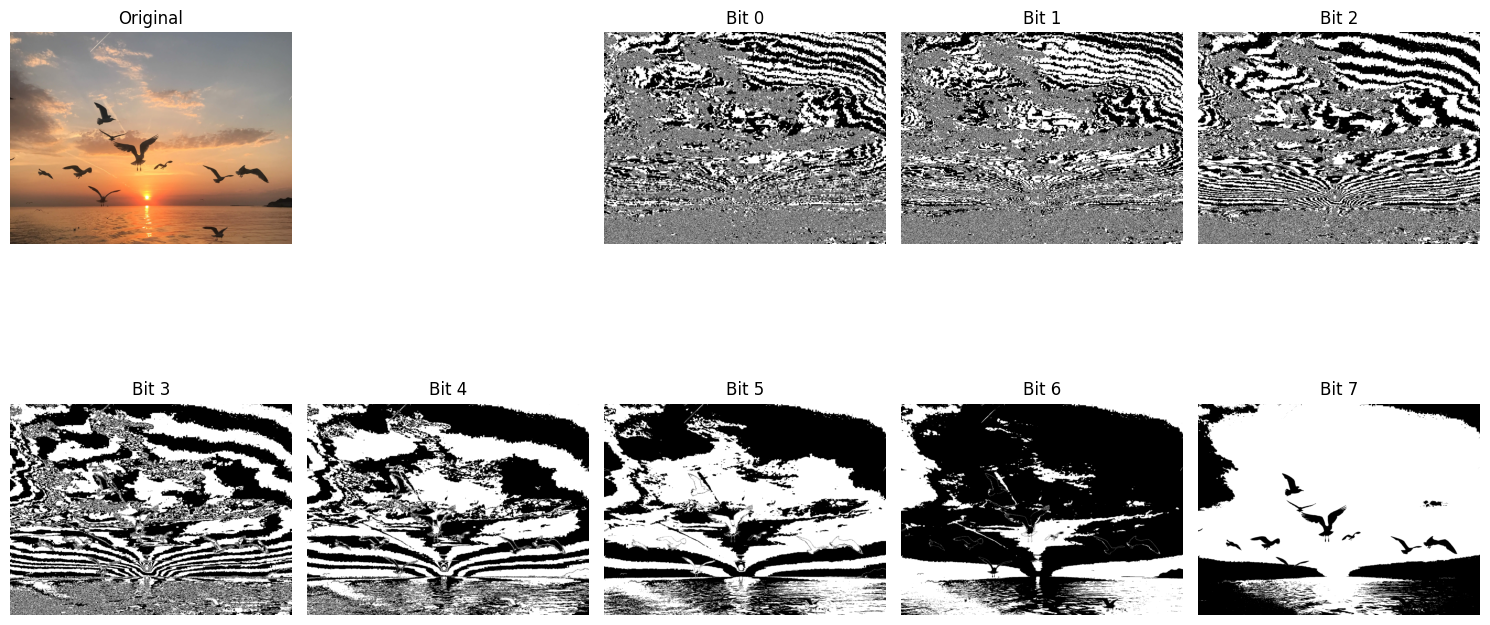

In [18]:
def extract_bit_planes(image):
    """
    Extrai os planos de bits de uma imagem.
    Retorna uma lista com os 8 planos de bits.
    """
    bit_planes = []
    for bit in range(8):
        plane = ((image >> bit) & 1) * 255
        bit_planes.append(plane.astype(np.uint8))
    return bit_planes

def analyze_bit_planes(bit_planes):
    """
    Analisa os planos de bits para determinar quais contêm mais ruído.
    Retorna uma pontuação de "importância" para cada plano.
    """
    scores = []
    for plane in bit_planes:
        local_var = cv2.Laplacian(plane, cv2.CV_64F).var()
        histogram = cv2.calcHist([plane], [0], None, [256], [0, 256])
        histogram = histogram / histogram.sum()
        entropy = -np.sum(histogram * np.log2(histogram + 1e-7))
        
        score = entropy / (1 + local_var)
        scores.append(score)
    
    return scores

def remove_artifacts(image, min_bit=4, adaptive=True):
    """
    Remove artefatos usando fatiamento de bits com técnica melhorada.
    
    Parâmetros:
    - image: Imagem de entrada
    - min_bit: Número mínimo de bits significativos a manter
    - adaptive: Se True, usa análise adaptativa para escolher bits
    """
    if len(image.shape) == 3:
        hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(hsv_image)
        
        v_processed = np.zeros_like(v)
        bit_planes = extract_bit_planes(v)
        
        if adaptive:
            scores = analyze_bit_planes(bit_planes)
            scores = np.array(scores)
            scores = scores / np.max(scores)
            
            threshold = 0.5
            for i, score in enumerate(scores):
                if score > threshold or i >= min_bit:
                    v_processed |= ((v >> i) & 1) << i
        else:
            for i in range(min_bit, 8):
                v_processed |= ((v >> i) & 1) << i
        
        v_processed = cv2.fastNlMeansDenoising(v_processed, None, 10, 7, 21)
        
        hsv_processed = cv2.merge([h, s, v_processed])
        return cv2.cvtColor(hsv_processed, cv2.COLOR_HSV2BGR)
    
    else:
        processed = np.zeros_like(image)
        bit_planes = extract_bit_planes(image)
        
        if adaptive:
            scores = analyze_bit_planes(bit_planes)
            scores = np.array(scores)
            scores = scores / np.max(scores)
            
            threshold = 0.5
            for i, score in enumerate(scores):
                if score > threshold or i >= min_bit:
                    processed |= ((image >> i) & 1) << i
        else:
            for i in range(min_bit, 8):
                processed |= ((image >> i) & 1) << i
        
        processed = cv2.fastNlMeansDenoising(processed, None, 10, 7, 21)
        return processed

def enhance_contrast(image):
    """
    Melhora o contraste da imagem após a remoção de artefatos.
    """
    if len(image.shape) == 3:
        lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        l = clahe.apply(l)
        lab = cv2.merge([l, a, b])
        return cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    else:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        return clahe.apply(image)

def visualize_results(original, processed, bit_planes=None):
    """
    Visualiza a imagem original e opcionalmente os planos de bits.
    """
    if bit_planes is not None:
        rows = 2
        cols = 5
        plt.figure(figsize=(15, 8))
        
        plt.subplot(rows, cols, 1)
        plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB) if len(original.shape) == 3 else original, cmap='gray')
        plt.title('Original')
        plt.axis('off')  
       
        
        for i, plane in enumerate(bit_planes):
            plt.subplot(rows, cols, i + 3)
            plt.imshow(plane, cmap='gray')
            plt.title(f'Bit {i}')
            plt.axis('off')
    else:
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB) if len(original.shape) == 3 else original, cmap='gray')
        plt.title('Original')
        plt.axis('off')
        
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    image = cv2.imread("input/ex3.jpg")
    
    
    processed = remove_artifacts(image, min_bit=5, adaptive=True)
    
    processed = enhance_contrast(processed)
    
    if len(image.shape) == 3:
        bit_planes = extract_bit_planes(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
    else:
        bit_planes = extract_bit_planes(image)
    
    visualize_results(image, processed, bit_planes)

### **ATIVIDADE** 4
### Escreva uma função que realize o fatiamento de bits em uma imagem usando 4 núcleos do processador ao mesmo tempo

In [ ]:

def process_bit_plane(args):
    """
    Processa um único plano de bits.
    
    Args:
        args: tupla contendo (imagem, número do bit)
    Returns:
        plano de bits processado
    """
    image, bit = args
    return ((image >> bit) & 1) * 255

def parallel_bit_slicing(image, num_cores=4):
    """
    Realiza o fatiamento de bits usando processamento paralelo.
    
    Args:
        image: numpy array da imagem
        num_cores: número de núcleos a serem utilizados
    Returns:
        lista de planos de bits
    """
    num_cores = min(num_cores, cpu_count())
    
    if len(image.shape) == 3:
        channels = cv2.split(image)
        processed_channels = []
        
        for channel in channels:
            args = [(channel, bit) for bit in range(8)]
            
            with Pool(num_cores) as pool:
                bit_planes = pool.map(process_bit_plane, args)
                processed_channels.append([plane.astype(np.uint8) for plane in bit_planes])
        
        return processed_channels
    else:
        args = [(image, bit) for bit in range(8)]
        
        with Pool(num_cores) as pool:
            bit_planes = pool.map(process_bit_plane, args)
            return [plane.astype(np.uint8) for plane in bit_planes]

def reconstruct_image(bit_planes, start_bit=4):
    """
    Reconstrói a imagem a partir dos planos de bits selecionados.
    
    Args:
        bit_planes: lista de planos de bits
        start_bit: bit inicial para reconstrução (4 = 4 bits mais significativos)
    Returns:
        imagem reconstruída
    """
    reconstructed = np.zeros_like(bit_planes[0])
    for i in range(start_bit, 8):
        reconstructed |= (bit_planes[i] // 255) << i
    return reconstructed

def visualize_results(original, bit_planes, reconstructed=None):
    """
    Visualiza a imagem original, planos de bits e imagem reconstruída.
    """
    if isinstance(bit_planes[0], list):  
        num_channels = len(bit_planes)
        plt.figure(figsize=(15, 5*num_channels))
        
        for c, channel_planes in enumerate(bit_planes):
            channel_name = ['Blue', 'Green', 'Red'][c]
            
            for i, plane in enumerate(channel_planes):
                plt.subplot(num_channels, 8, c*8 + i + 1)
                plt.imshow(plane, cmap='gray')
                plt.title(f'{channel_name} Bit {i}')
                plt.axis('off')
    else:  
        rows = 2 if reconstructed is not None else 1
        plt.figure(figsize=(15, 5*rows))
        
        for i, plane in enumerate(bit_planes):
            plt.subplot(rows, 8, i + 1)
            plt.imshow(plane, cmap='gray')
            plt.title(f'Bit {i}')
            plt.axis('off')
        
        if reconstructed is not None:
            plt.subplot(rows, 2, 3)
            plt.imshow(original, cmap='gray')
            plt.title('Original')
            plt.axis('off')
            
            plt.subplot(rows, 2, 4)
            plt.imshow(reconstructed, cmap='gray')
            plt.title('Reconstruída')
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    image = cv2.imread("input/ex4.jpg")
    
    if image is None:
        raise ValueError("Não foi possível carregar a imagem!")
    
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    
    print("Iniciando processamento paralelo...")
    bit_planes = parallel_bit_slicing(gray, num_cores=4)
    print("Processamento concluído!")
    
    reconstructed = reconstruct_image(bit_planes, start_bit=4)
    
    visualize_results(gray, bit_planes, reconstructed)
   

Iniciando processamento paralelo...


### **ATIVIDADE** 5
### Usando o resultado da atividade 2, escreva um relatório respondendo se o fatiamento de bits pode ser utilizado nos 5 tipos de imagem ou em quais deles podem ser recomendados o uso

<h4> O fatiamento de bits pode ser aplicado em qualquer imagem digital, por serem compostas por bits, entretanto possui maior eficácia em alguns tipos específicos de imagem. 
Sendo recomendado para imagens de ultrassom, satélite, tomografia computadorizada e ressonância magnética. No qual, no primeiro caso, as de ultrassom, é recomendado para o destaque em estruturas específicas, em que os bits mais significativos são compostos por estruturas anatômicas. Enquanto para as imagens de satélite, é essencial para análise de características do terreno, podendo auxiliar na identificação de coberturas do solo.
Para as imagens de tomografia, auxilia na visualização de diferentes densidades do tecido, além de destacar as estruturas ósseas. Por fim, para a ressonância magnética, ele é útil para destacar diferentes tipos de tecidos, auxiliando na identificação de anomalias. 
Portanto, o fatiamento de bits é mais recomendado para imagens médicas e de sensoriamento remoto, pois os dados são concentrados em determinados níveis de bits. </h4>